In [1]:
# Cell 1: Setup and Install
!pip install torch torchvision pillow matplotlib numpy scikit-image -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import os
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Setup complete!")
print(f"Device: {device}")

Setup complete!
Device: cuda


In [2]:
# Cell 2: Denoising CNN Model (similar to SRCNN)
class DnCNN(nn.Module):
    """
    Denoising Convolutional Neural Network
    Similar architecture to SRCNN but optimized for denoising
    """
    def __init__(self, num_layers=5, num_features=64):
        super(DnCNN, self).__init__()

        layers = []

        # First layer: 3 input channels (RGB) to 64 features
        layers.append(nn.Conv2d(3, num_features, kernel_size=3, padding=1))
        layers.append(nn.ReLU(inplace=True))

        # Middle layers: 64 features to 64 features
        for _ in range(num_layers - 2):
            layers.append(nn.Conv2d(num_features, num_features, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(num_features))
            layers.append(nn.ReLU(inplace=True))

        # Last layer: 64 features to 3 output channels (RGB)
        layers.append(nn.Conv2d(num_features, 3, kernel_size=3, padding=1))

        self.dncnn = nn.Sequential(*layers)

    def forward(self, x):
        # Learn the noise (residual)
        noise = self.dncnn(x)
        # Return clean image (input - predicted noise)
        return x - noise

# Initialize model
model = DnCNN(num_layers=7, num_features=64).to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"DnCNN Model initialized")
print(f"Parameters: {total_params:,}")
print(f"Architecture: 7 layers, residual learning")

DnCNN Model initialized
Parameters: 188,803
Architecture: 7 layers, residual learning


In [3]:
# Cell 3: Denoising Dataset
class DenoisingDataset(Dataset):
    """
    Dataset that creates noisy/clean image pairs
    """
    def __init__(self, image_paths, noise_level=25, patch_size=64):
        self.image_paths = image_paths
        self.noise_level = noise_level  # Gaussian noise standard deviation
        self.patch_size = patch_size

    def __len__(self):
        return len(self.image_paths) * 100  # 100 patches per image

    def __getitem__(self, idx):
        # Select image
        img_idx = idx % len(self.image_paths)
        img = Image.open(self.image_paths[img_idx]).convert('RGB')

        # Ensure image is large enough
        if img.size[0] < self.patch_size or img.size[1] < self.patch_size:
            img = img.resize((self.patch_size * 2, self.patch_size * 2), Image.BICUBIC)

        # Random crop
        i = np.random.randint(0, img.size[0] - self.patch_size)
        j = np.random.randint(0, img.size[1] - self.patch_size)
        clean_patch = img.crop((i, j, i + self.patch_size, j + self.patch_size))

        # Convert to array and add Gaussian noise
        clean_arr = np.array(clean_patch).astype(np.float32) / 255.0
        noise = np.random.normal(0, self.noise_level / 255.0, clean_arr.shape)
        noisy_arr = clean_arr + noise
        noisy_arr = np.clip(noisy_arr, 0, 1)  # Clip to valid range

        # Convert to tensors
        to_tensor = transforms.ToTensor()
        noisy_tensor = torch.from_numpy(noisy_arr).permute(2, 0, 1).float()
        clean_tensor = torch.from_numpy(clean_arr).permute(2, 0, 1).float()

        return noisy_tensor, clean_tensor

print("Denoising dataset class ready")

Denoising dataset class ready


In [4]:
# Cell 4: Training function
def train_denoising(model, train_loader, num_epochs=30, lr=1e-3):
    """
    Train the denoising model
    """
    model.train()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    losses = []

    print(f" Starting denoising training...")
    print(f"   Epochs: {num_epochs}")
    print(f"   Learning rate: {lr}")
    print(f"   Batches per epoch: {len(train_loader)}\n")
    print("=" * 70)

    for epoch in range(num_epochs):
        epoch_loss = 0
        num_batches = 0

        for batch_idx, (noisy, clean) in enumerate(train_loader):
            noisy = noisy.to(device)
            clean = clean.to(device)

            # Forward pass
            optimizer.zero_grad()
            denoised = model(noisy)
            loss = criterion(denoised, clean)

            # Backward pass
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

            # Print progress every 50 batches
            if (batch_idx + 1) % 50 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{batch_idx+1}/{len(train_loader)}] Loss: {loss.item():.6f}")

        avg_loss = epoch_loss / num_batches
        losses.append(avg_loss)

        print(f"\n{'='*70}")
        print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {avg_loss:.6f}")
        print('='*70 + '\n')

        # Save checkpoint every 10 epochs
        if (epoch + 1) % 10 == 0:
            torch.save(model.state_dict(), f'dncnn_epoch_{epoch+1}.pth')
            print(f"Checkpoint saved\n")

    # Save final model
    torch.save(model.state_dict(), 'dncnn_final.pth')
    print("\n Training complete!")
    print(" Model saved as: dncnn_final.pth")

    return losses

print("Training function ready")

Training function ready


In [5]:
# Cell 5: Visualization functions
def plot_training_curve(losses):
    """Plot training loss"""
    plt.figure(figsize=(10, 6))
    plt.plot(losses, linewidth=2, color='blue')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('MSE Loss', fontsize=12)
    plt.title('Denoising Training Loss (Should Decrease!)', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"\n Training Summary:")
    print(f"   Initial loss: {losses[0]:.6f}")
    print(f"   Final loss: {losses[-1]:.6f}")
    print(f"   Improvement: {(losses[0]-losses[-1])/losses[0]*100:.1f}%")

def calculate_metrics(img_original, img_processed):
    """Calculate PSNR and SSIM"""
    if img_original.size != img_processed.size:
        img_processed = img_processed.resize(img_original.size, Image.LANCZOS)

    img_orig = np.array(img_original)
    img_proc = np.array(img_processed)

    psnr_value = psnr(img_orig, img_proc, data_range=255)
    ssim_value = ssim(img_orig, img_proc, multichannel=True,
                     data_range=255, channel_axis=2)

    return psnr_value, ssim_value

def visualize_denoising(img_clean, img_noisy, img_denoised, metrics_noisy, metrics_denoised, noise_level):
    """Display denoising comparison"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Clean original
    axes[0].imshow(img_clean)
    axes[0].set_title('Original (Clean)', fontsize=14, fontweight='bold')
    axes[0].axis('off')

    # Noisy
    psnr_noisy, ssim_noisy = metrics_noisy
    axes[1].imshow(img_noisy)
    axes[1].set_title(f'Noisy (σ={noise_level})\nPSNR: {psnr_noisy:.2f} dB | SSIM: {ssim_noisy:.3f}',
                     fontsize=12, color='red')
    axes[1].axis('off')

    # Denoised
    psnr_den, ssim_den = metrics_denoised
    improvement = psnr_den - psnr_noisy
    axes[2].imshow(img_denoised)
    axes[2].set_title(f'Denoised (DnCNN)\nPSNR: {psnr_den:.2f} dB (+{improvement:.2f}) | SSIM: {ssim_den:.3f}',
                     fontsize=12, color='green')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    # Print summary
    print("\n" + "="*70)
    print(" DENOISING RESULTS")
    print("="*70)
    print(f"Original → Noisy:    {psnr_noisy:.2f} dB (degraded by noise)")
    print(f"Noisy → Denoised:    {psnr_den:.2f} dB")
    print(f"Improvement:         +{improvement:.2f} dB")
    print(f"\nSSIM Improvement:    {ssim_noisy:.3f} → {ssim_den:.3f}")
    print("="*70)

print(" Visualization functions ready")

 Visualization functions ready


In [6]:
# Cell 6: Test function
def test_denoising(image_path, model, noise_level=25):
    """
    Test denoising on a single image
    """
    print(f"\n Testing denoising (noise level: {noise_level})...\n")

    # Load clean image
    img_clean = Image.open(image_path).convert('RGB')
    print(f"Image size: {img_clean.size}")

    # Add noise
    clean_arr = np.array(img_clean).astype(np.float32) / 255.0
    noise = np.random.normal(0, noise_level / 255.0, clean_arr.shape)
    noisy_arr = np.clip(clean_arr + noise, 0, 1)
    img_noisy = Image.fromarray((noisy_arr * 255).astype(np.uint8))

    print(f"Added Gaussian noise with σ={noise_level}\n")

    # Denoise with model
    model.eval()
    to_tensor = transforms.ToTensor()
    noisy_tensor = to_tensor(img_noisy).unsqueeze(0).to(device)

    with torch.no_grad():
        denoised_tensor = model(noisy_tensor)
        denoised_tensor = torch.clamp(denoised_tensor, 0, 1)

    to_pil = transforms.ToPILImage()
    img_denoised = to_pil(denoised_tensor.squeeze(0).cpu())

    # Calculate metrics
    print(" Calculating metrics...")

    # Metrics for noisy image
    img_noisy_scaled = Image.fromarray((noisy_arr * 255).astype(np.uint8))
    metrics_noisy = calculate_metrics(img_clean, img_noisy_scaled)

    # Metrics for denoised image
    metrics_denoised = calculate_metrics(img_clean, img_denoised)

    # Visualize
    visualize_denoising(img_clean, img_noisy, img_denoised,
                       metrics_noisy, metrics_denoised, noise_level)

    return img_noisy, img_denoised, metrics_noisy, metrics_denoised

print(" Test function ready")

 Test function ready


 STEP 1: Upload Training Images

 What you need:
   • 15-25 clean, high-quality images
   • Any resolution (will be auto-processed)
   • Diverse content (landscapes, portraits, objects, etc.)

 The cleaner your training images, the better the denoising!
   • No blur, no noise in training images
   • Good lighting, sharp focus
----------------------------------------------------------------------



Saving christian-rodriguez-4FLu9SUJ1XE-unsplash.jpg to christian-rodriguez-4FLu9SUJ1XE-unsplash.jpg
Saving christoph-nolte-9Fa_wOPkS7c-unsplash.jpg to christoph-nolte-9Fa_wOPkS7c-unsplash.jpg
Saving christoph-nolte-jvKwiChSaP8-unsplash.jpg to christoph-nolte-jvKwiChSaP8-unsplash.jpg
Saving christopher-stites-Ck7fJZQE0z0-unsplash.jpg to christopher-stites-Ck7fJZQE0z0-unsplash.jpg
Saving daniel-j-schwarz-88yShPotLlI-unsplash.jpg to daniel-j-schwarz-88yShPotLlI-unsplash.jpg
Saving daniil-silantev-w5JLGSyYLuQ-unsplash.jpg to daniil-silantev-w5JLGSyYLuQ-unsplash.jpg
Saving evgeni-tcherkasski-4I12DYcs0tc-unsplash.jpg to evgeni-tcherkasski-4I12DYcs0tc-unsplash.jpg
Saving evgeni-tcherkasski-hegb9Y8dKos-unsplash.jpg to evgeni-tcherkasski-hegb9Y8dKos-unsplash.jpg
Saving ingmar-_fo94DN8yXo-unsplash.jpg to ingmar-_fo94DN8yXo-unsplash.jpg
Saving intricate-explorer-BzojLB8diyg-unsplash.jpg to intricate-explorer-BzojLB8diyg-unsplash.jpg
Saving jim-luo-4sNmMP0ySz4-unsplash.jpg to jim-luo-4sNmMP0ySz4-u

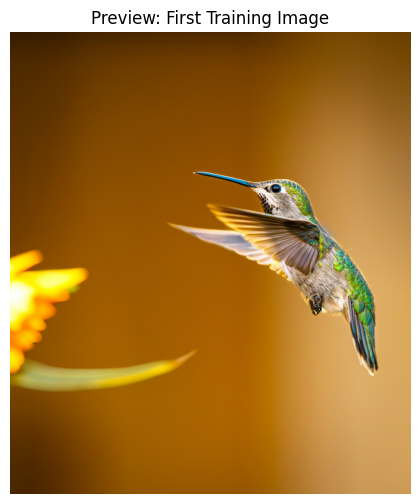

In [7]:
# Cell 7: Upload training images
print("="*70)
print(" STEP 1: Upload Training Images")
print("="*70)
print("\n What you need:")
print("   • 15-25 clean, high-quality images")
print("   • Any resolution (will be auto-processed)")
print("   • Diverse content (landscapes, portraits, objects, etc.)")
print("\n The cleaner your training images, the better the denoising!")
print("   • No blur, no noise in training images")
print("   • Good lighting, sharp focus")
print("-"*70 + "\n")

uploaded = files.upload()

if uploaded:
    image_paths = list(uploaded.keys())
    print(f"\n Uploaded {len(image_paths)} training images")

    # Display first image
    preview = Image.open(image_paths[0])
    plt.figure(figsize=(6, 6))
    plt.imshow(preview)
    plt.title('Preview: First Training Image')
    plt.axis('off')
    plt.show()
else:
    print(" No images uploaded!")
    image_paths = []

In [8]:
# Cell 7.5: Preprocess 4K images to reasonable size
print("\n" + "="*70)
print(" STEP 1.5: Preprocessing 4K Images")
print("="*70 + "\n")

os.makedirs('preprocessed_images', exist_ok=True)

preprocessed_paths = []

for i, img_path in enumerate(image_paths):
    img = Image.open(img_path).convert('RGB')
    original_size = img.size

    # Resize to 1600px max dimension (good balance of quality and speed)
    max_size = 1600
    if max(img.size) > max_size:
        ratio = max_size / max(img.size)
        new_size = (int(img.size[0] * ratio), int(img.size[1] * ratio))
        img = img.resize(new_size, Image.LANCZOS)

    # Save
    new_path = f'preprocessed_images/img_{i}.png'
    img.save(new_path, optimize=True)
    preprocessed_paths.append(new_path)

    # Get file sizes
    orig_size_mb = os.path.getsize(img_path) / (1024*1024) if os.path.exists(img_path) else 0
    new_size_mb = os.path.getsize(new_path) / (1024*1024)

    print(f"Image {i+1}/{len(image_paths)}: {original_size} → {img.size} ({orig_size_mb:.1f}MB → {new_size_mb:.1f}MB)")

# Use preprocessed images
image_paths = preprocessed_paths

print(f"\n All images preprocessed!")


 STEP 1.5: Preprocessing 4K Images

Image 1/22: (2658, 3063) → (1388, 1600) (1.0MB → 2.2MB)
Image 2/22: (3600, 4500) → (1280, 1600) (1.8MB → 2.0MB)
Image 3/22: (3600, 4500) → (1280, 1600) (1.7MB → 1.8MB)
Image 4/22: (2048, 3089) → (1060, 1600) (1.6MB → 3.0MB)
Image 5/22: (4160, 6240) → (1066, 1599) (5.4MB → 2.7MB)
Image 6/22: (2830, 4240) → (1067, 1600) (3.4MB → 2.2MB)
Image 7/22: (3686, 5521) → (1068, 1600) (4.6MB → 2.9MB)
Image 8/22: (5780, 3858) → (1600, 1067) (4.2MB → 2.2MB)
Image 9/22: (4000, 6000) → (1066, 1600) (3.8MB → 1.6MB)
Image 10/22: (5457, 8268) → (1056, 1600) (15.9MB → 3.1MB)
Image 11/22: (2048, 3089) → (1060, 1600) (2.3MB → 3.4MB)
Image 12/22: (4000, 6000) → (1066, 1600) (1.3MB → 1.3MB)
Image 13/22: (2676, 3948) → (1084, 1600) (1.1MB → 1.4MB)
Image 14/22: (5504, 8256) → (1066, 1600) (11.8MB → 2.2MB)
Image 15/22: (6336, 9504) → (1066, 1600) (6.5MB → 2.3MB)
Image 16/22: (864, 1288) → (864, 1288) (1.1MB → 0.9MB)
Image 17/22: (8307, 5538) → (1600, 1066) (4.7MB → 1.6MB)
Ima

In [9]:
# Cell 8: Create dataset and dataloader
if image_paths:
    print("\n" + "="*70)
    print(" STEP 2: Creating Training Dataset")
    print("="*70 + "\n")

    noise_level = 25  # Standard deviation of Gaussian noise (0-50 range)
    patch_size = 64   # Size of training patches
    batch_size = 16

    # Create dataset
    dataset = DenoisingDataset(image_paths, noise_level=noise_level, patch_size=patch_size)
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

    print(f"Dataset configuration:")
    print(f"  Noise level: σ={noise_level} (moderate noise)")
    print(f"  Patch size: {patch_size}×{patch_size}")
    print(f"  Batch size: {batch_size}")
    print(f"  Total patches: {len(dataset)}")
    print(f"  Batches per epoch: {len(train_loader)}")
    print("\n Dataset ready!")


 STEP 2: Creating Training Dataset

Dataset configuration:
  Noise level: σ=25 (moderate noise)
  Patch size: 64×64
  Batch size: 16
  Total patches: 2200
  Batches per epoch: 138

 Dataset ready!


 Visualizing Noisy Samples from Dataset

Showing 4 random samples from training dataset...



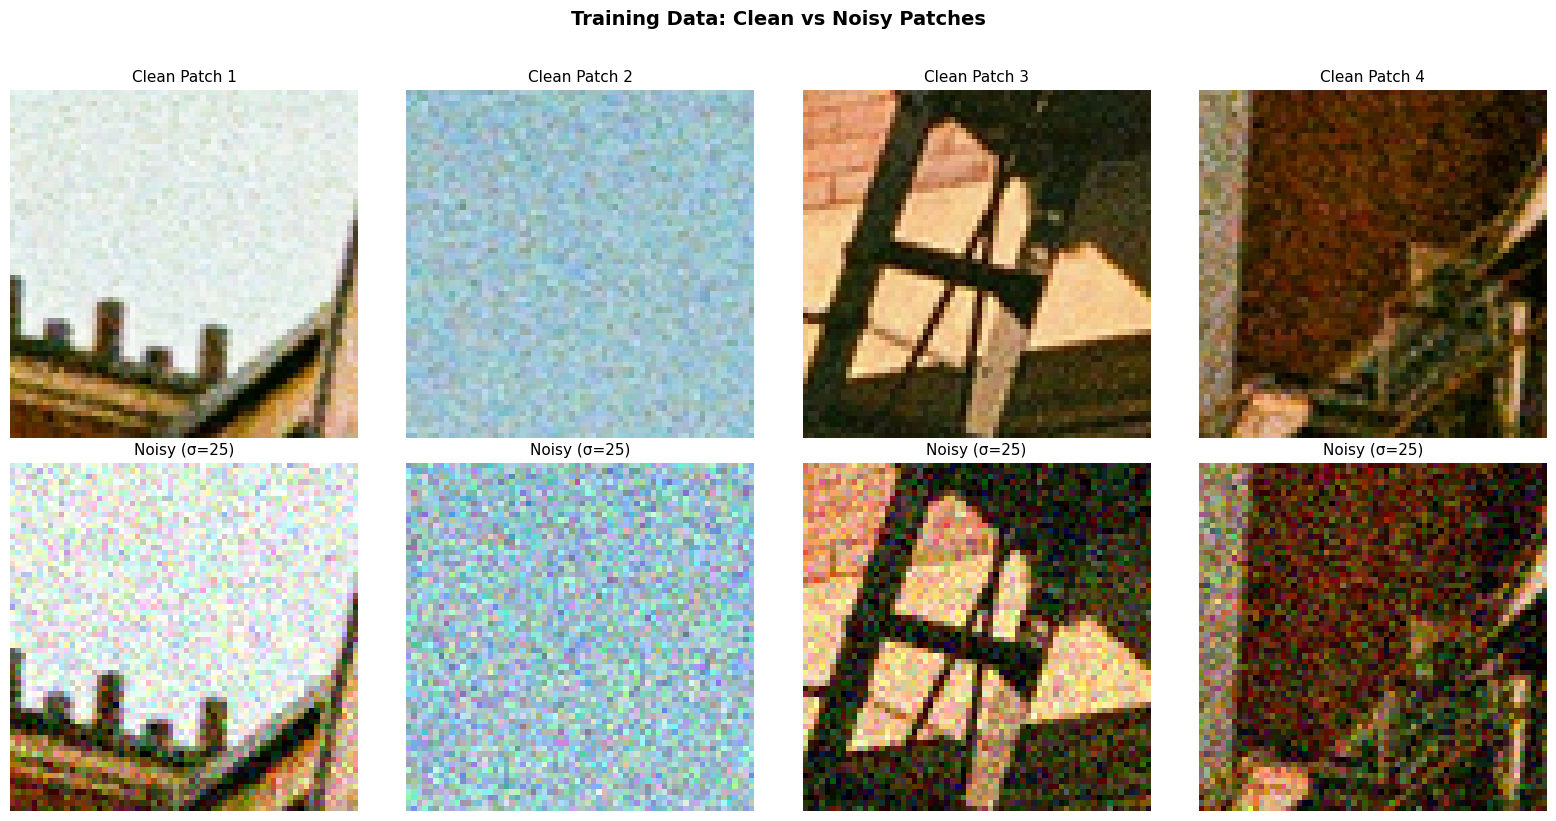

 This is what the model trains on!
   • Top row: Clean target patches (64×64)
   • Bottom row: Noisy input patches (σ=25)
   • Model learns: Noisy → Clean


In [10]:
# Cell: Visualize noisy samples from dataset
print("="*70)
print(" Visualizing Noisy Samples from Dataset")
print("="*70 + "\n")

if 'dataset' in locals():
    # Get a few random samples
    num_samples = 4

    fig, axes = plt.subplots(2, num_samples, figsize=(16, 8))

    print(f"Showing {num_samples} random samples from training dataset...\n")

    for i in range(num_samples):
        # Get random sample
        idx = np.random.randint(0, len(dataset))
        noisy_tensor, clean_tensor = dataset[idx]

        # Convert tensors to images
        to_pil = transforms.ToPILImage()
        noisy_img = to_pil(noisy_tensor)
        clean_img = to_pil(clean_tensor)

        # Display clean patch
        axes[0, i].imshow(clean_img)
        axes[0, i].set_title(f'Clean Patch {i+1}', fontsize=11)
        axes[0, i].axis('off')

        # Display noisy patch
        axes[1, i].imshow(noisy_img)
        axes[1, i].set_title(f'Noisy (σ=25)', fontsize=11)
        axes[1, i].axis('off')

    plt.suptitle('Training Data: Clean vs Noisy Patches', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

    print(" This is what the model trains on!")
    print(f"   • Top row: Clean target patches ({patch_size}×{patch_size})")
    print(f"   • Bottom row: Noisy input patches (σ={noise_level})")
    print(f"   • Model learns: Noisy → Clean")

else:
    print(" Dataset not created yet! Run Cell 8 first.")


 STEP 3: Training Denoising Model

 Estimated time: 30-40 minutes
 Loss should decrease steadily

 Starting denoising training...
   Epochs: 30
   Learning rate: 0.001
   Batches per epoch: 138

Epoch [1/30] Batch [50/138] Loss: 0.008554
Epoch [1/30] Batch [100/138] Loss: 0.005764

Epoch [1/30] Average Loss: 0.012152

Epoch [2/30] Batch [50/138] Loss: 0.002736
Epoch [2/30] Batch [100/138] Loss: 0.002418

Epoch [2/30] Average Loss: 0.002832

Epoch [3/30] Batch [50/138] Loss: 0.002574
Epoch [3/30] Batch [100/138] Loss: 0.002331

Epoch [3/30] Average Loss: 0.002116

Epoch [4/30] Batch [50/138] Loss: 0.001909
Epoch [4/30] Batch [100/138] Loss: 0.002142

Epoch [4/30] Average Loss: 0.001932

Epoch [5/30] Batch [50/138] Loss: 0.002229
Epoch [5/30] Batch [100/138] Loss: 0.001730

Epoch [5/30] Average Loss: 0.001762

Epoch [6/30] Batch [50/138] Loss: 0.001770
Epoch [6/30] Batch [100/138] Loss: 0.001492

Epoch [6/30] Average Loss: 0.001634

Epoch [7/30] Batch [50/138] Loss: 0.001543
Epoch [7/30

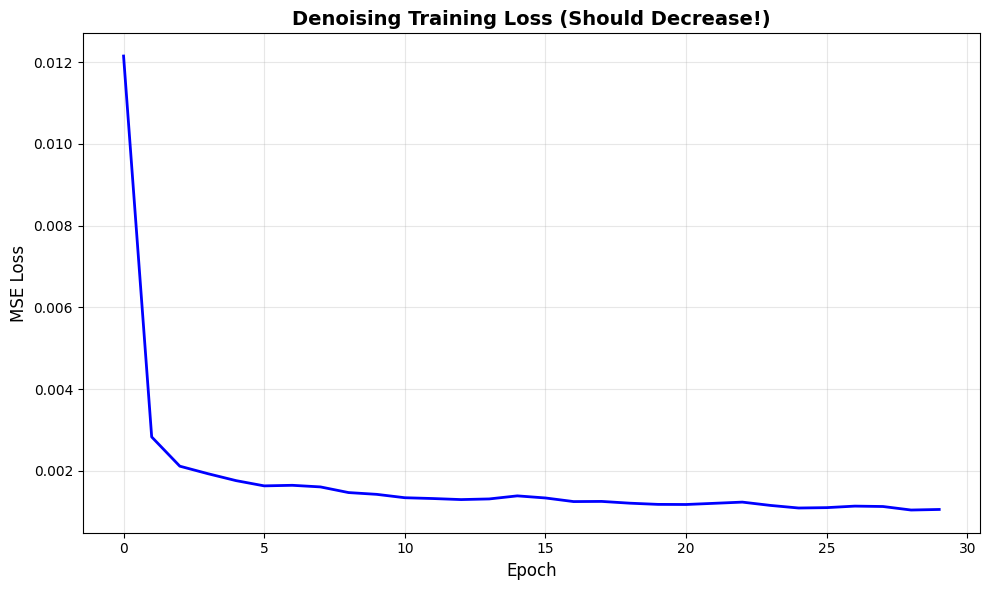


 Training Summary:
   Initial loss: 0.012152
   Final loss: 0.001057
   Improvement: 91.3%


In [11]:
# Cell 9: Train the model
if image_paths:
    print("\n" + "="*70)
    print(" STEP 3: Training Denoising Model")
    print("="*70 + "\n")

    num_epochs = 30

    print(f" Estimated time: 30-40 minutes")
    print(f" Loss should decrease steadily\n")

    # Train!
    losses = train_denoising(model, train_loader, num_epochs=num_epochs, lr=1e-3)

    # Plot training curve
    print("\n Training Progress:")
    plot_training_curve(losses)

In [23]:
# Cell 10: Upload test image
print("\n" + "="*70)
print(" STEP 4: Upload Test Image")
print("="*70)
print("\n Upload ONE clean image to test denoising")
print("   • Different from training images")
print("   • High quality, no existing noise")
print("   • We'll add noise and then denoise it\n")

test_uploaded = files.upload()

if test_uploaded:
    test_image = list(test_uploaded.keys())[0]
    print(f"\n Test image: {test_image}")
else:
    print(" No test image uploaded!")
    test_image = None


 STEP 4: Upload Test Image

 Upload ONE clean image to test denoising
   • Different from training images
   • High quality, no existing noise
   • We'll add noise and then denoise it



Saving noisy_house.jpg to noisy_house.jpg

 Test image: noisy_house.jpg



 BONUS: Testing Different Noise Levels


──────────────────────────────────────────────────────────────────────
Testing with noise level σ=15
──────────────────────────────────────────────────────────────────────

 Testing denoising (noise level: 15)...

Image size: (300, 160)
Added Gaussian noise with σ=15

 Calculating metrics...


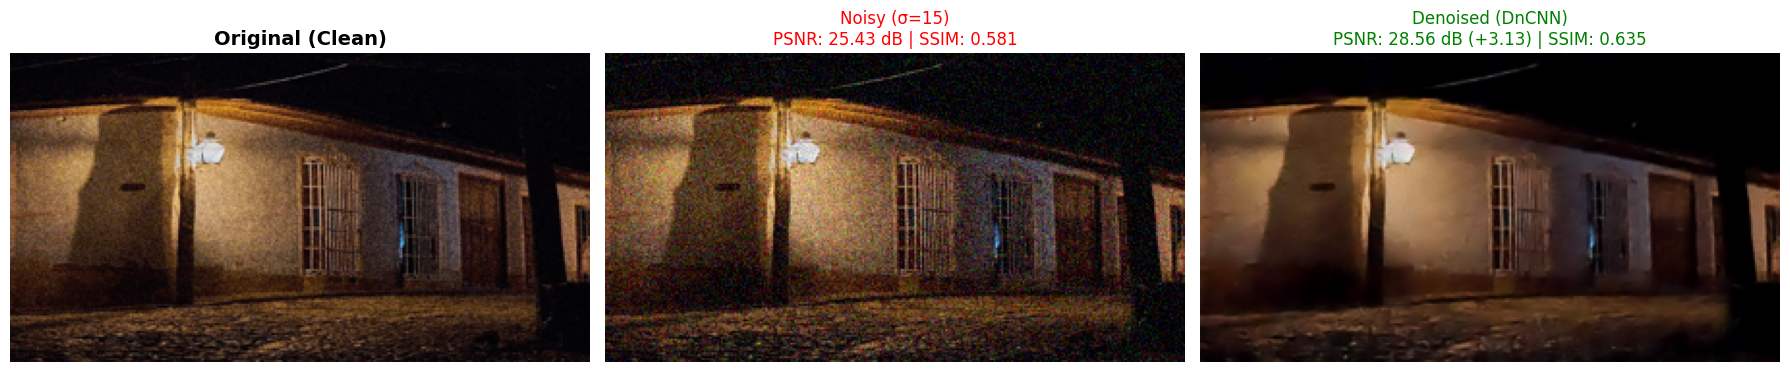


 DENOISING RESULTS
Original → Noisy:    25.43 dB (degraded by noise)
Noisy → Denoised:    28.56 dB
Improvement:         +3.13 dB

SSIM Improvement:    0.581 → 0.635

 Improvement at σ=15: +3.13 dB


──────────────────────────────────────────────────────────────────────
Testing with noise level σ=25
──────────────────────────────────────────────────────────────────────

 Testing denoising (noise level: 25)...

Image size: (300, 160)
Added Gaussian noise with σ=25

 Calculating metrics...


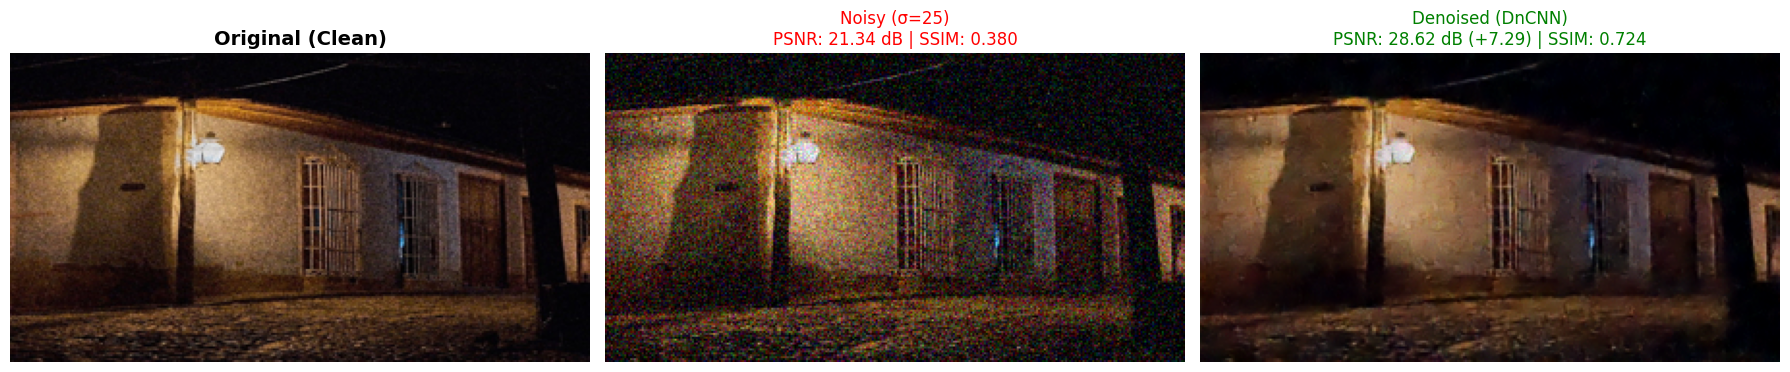


 DENOISING RESULTS
Original → Noisy:    21.34 dB (degraded by noise)
Noisy → Denoised:    28.62 dB
Improvement:         +7.29 dB

SSIM Improvement:    0.380 → 0.724

 Improvement at σ=25: +7.29 dB


──────────────────────────────────────────────────────────────────────
Testing with noise level σ=35
──────────────────────────────────────────────────────────────────────

 Testing denoising (noise level: 35)...

Image size: (300, 160)
Added Gaussian noise with σ=35

 Calculating metrics...


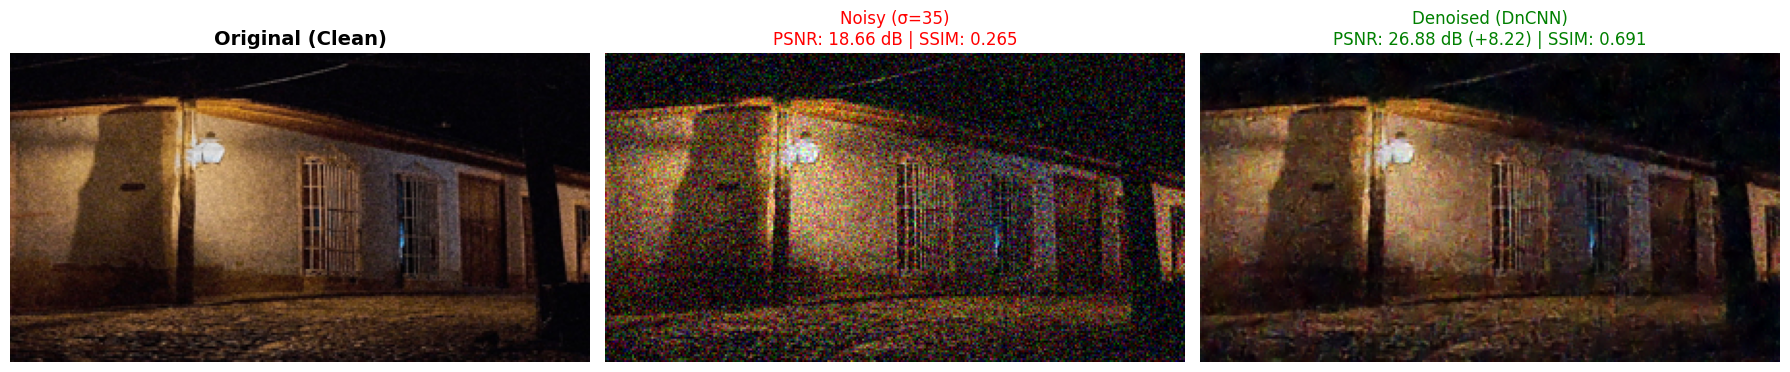


 DENOISING RESULTS
Original → Noisy:    18.66 dB (degraded by noise)
Noisy → Denoised:    26.88 dB
Improvement:         +8.22 dB

SSIM Improvement:    0.265 → 0.691

 Improvement at σ=35: +8.22 dB


──────────────────────────────────────────────────────────────────────
Testing with noise level σ=50
──────────────────────────────────────────────────────────────────────

 Testing denoising (noise level: 50)...

Image size: (300, 160)
Added Gaussian noise with σ=50

 Calculating metrics...


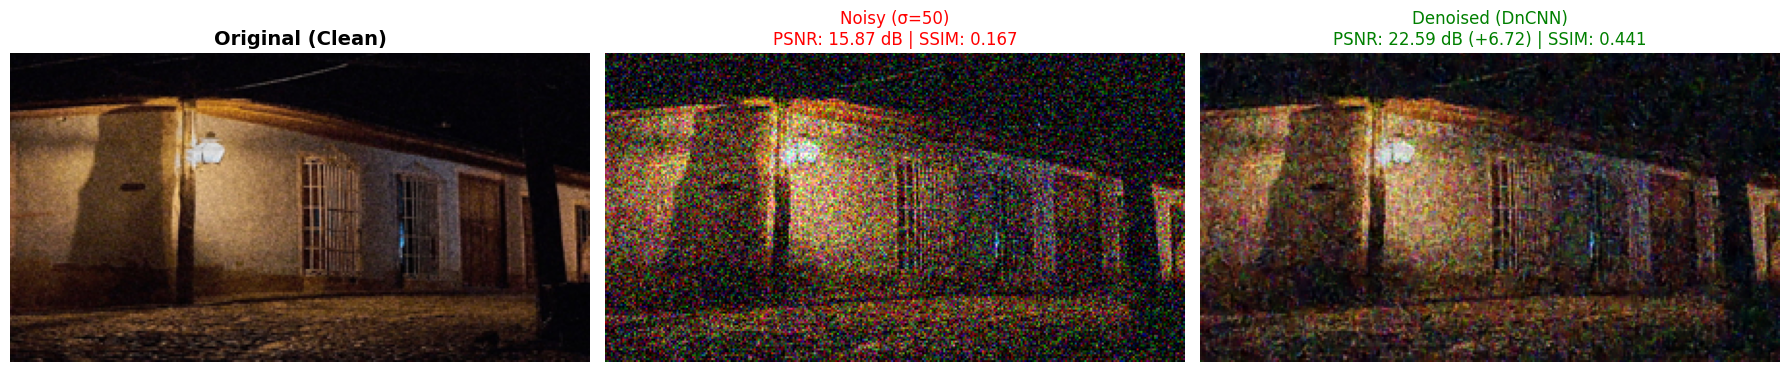


 DENOISING RESULTS
Original → Noisy:    15.87 dB (degraded by noise)
Noisy → Denoised:    22.59 dB
Improvement:         +6.72 dB

SSIM Improvement:    0.167 → 0.441

 Improvement at σ=50: +6.72 dB



In [24]:
# Cell 12: Test with different noise levels
if test_image:
    print("\n" + "="*70)
    print(" BONUS: Testing Different Noise Levels")
    print("="*70 + "\n")

    for noise in [15, 25, 35, 50]:
        print(f"\n{'─'*70}")
        print(f"Testing with noise level σ={noise}")
        print('─'*70)

        _, _, metrics_n, metrics_d = test_denoising(test_image, model, noise_level=noise)

        improvement = metrics_d[0] - metrics_n[0]
        print(f"\n Improvement at σ={noise}: +{improvement:.2f} dB\n")


 STEP 5: Testing Denoising

 Testing denoising (noise level: 25)...

Image size: (300, 160)
Added Gaussian noise with σ=25

 Calculating metrics...


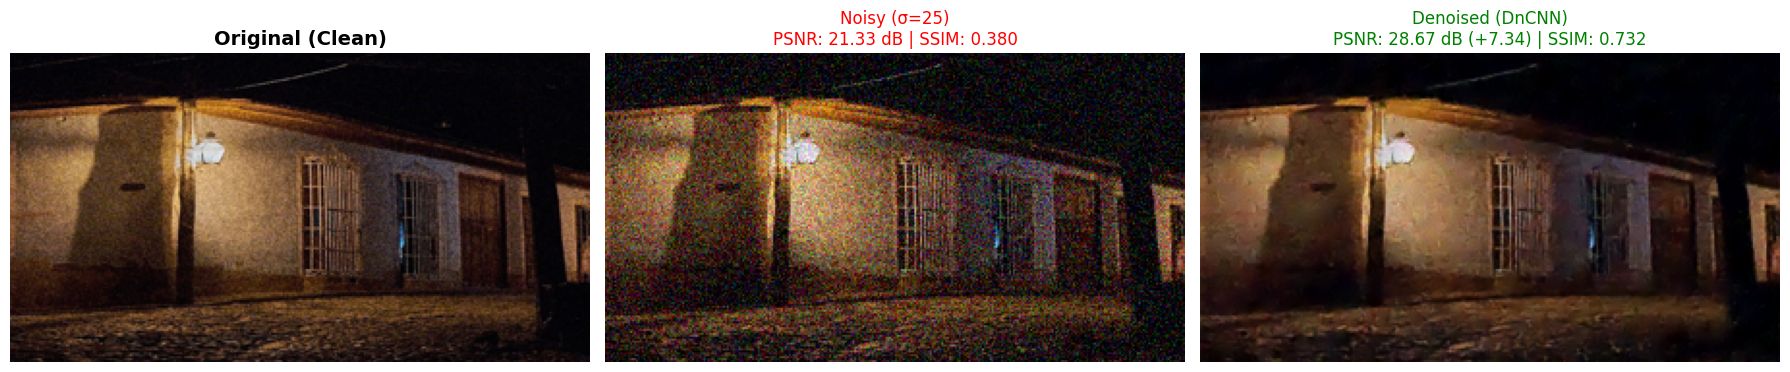


 DENOISING RESULTS
Original → Noisy:    21.33 dB (degraded by noise)
Noisy → Denoised:    28.67 dB
Improvement:         +7.34 dB

SSIM Improvement:    0.380 → 0.732



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
# Cell 11: Test and see results!
if test_image:
    print("\n" + "="*70)
    print(" STEP 5: Testing Denoising")
    print("="*70)

    # Test with noise level 25 (moderate)
    img_noisy, img_denoised, metrics_n, metrics_d = test_denoising(test_image, model, noise_level=25)

    # Save results
    img_noisy.save('noisy_house.png')
    img_denoised.save('denoised_house.png')

    print("\n Downloading results...")
    files.download('noisy_house.png')
    files.download('denoised_house.png')

In [26]:
# Cell: Test on Fashion MNIST (FIXED)
print("="*70)
print(" Testing Denoising on Fashion MNIST Dataset")
print("="*70 + "\n")

# Download Fashion MNIST
from torchvision import datasets
import torchvision.transforms as transforms

print(" Downloading Fashion MNIST dataset...")
fashion_mnist = datasets.FashionMNIST(root='./data', train=False, download=True)

print(f" Dataset loaded: {len(fashion_mnist)} test images\n")

# Fashion MNIST class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Select 10 random images
np.random.seed(42)
test_indices = np.random.choice(len(fashion_mnist), 10, replace=False)

print(f"Testing on 10 random Fashion MNIST images...\n")

# Noise level to add
noise_level = 50  # Aggressive noise for grayscale images

# Process images
results = []

for idx in test_indices:
    img, label = fashion_mnist[idx]

    # Convert grayscale to RGB (model expects 3 channels)
    img_rgb = img.convert('RGB')

    # Resize to larger size (28x28 is too small, upscale to 128x128)
    img_large = img_rgb.resize((128, 128), Image.BICUBIC)

    # Convert to array and add noise
    clean_arr = np.array(img_large).astype(np.float32) / 255.0  # float32!
    noise = np.random.normal(0, noise_level / 255.0, clean_arr.shape).astype(np.float32)  # float32!
    noisy_arr = np.clip(clean_arr + noise, 0, 1).astype(np.float32)  # float32!

    # Convert to tensors (explicitly float32)
    noisy_tensor = torch.from_numpy(noisy_arr).permute(2, 0, 1).unsqueeze(0).float().to(device)  # .float()!

    # Denoise
    model.eval()
    with torch.no_grad():
        denoised_tensor = model(noisy_tensor)
        denoised_tensor = torch.clamp(denoised_tensor, 0, 1)

    # Convert back to images
    to_pil = transforms.ToPILImage()
    noisy_img = Image.fromarray((noisy_arr * 255).astype(np.uint8))
    denoised_img = to_pil(denoised_tensor.squeeze(0).cpu())

    # Calculate metrics
    psnr_noisy = psnr(np.array(img_large), np.array(noisy_img), data_range=255)
    psnr_denoised = psnr(np.array(img_large), np.array(denoised_img), data_range=255)

    results.append({
        'clean': img_large,
        'noisy': noisy_img,
        'denoised': denoised_img,
        'label': class_names[label],
        'psnr_noisy': psnr_noisy,
        'psnr_denoised': psnr_denoised,
        'improvement': psnr_denoised - psnr_noisy
    })

    print(f"Image {len(results)}: {class_names[label]:15s} | Noisy: {psnr_noisy:.2f} dB → Denoised: {psnr_denoised:.2f} dB (+{psnr_denoised - psnr_noisy:.2f} dB)")

print("\n Processing complete!")

 Testing Denoising on Fashion MNIST Dataset

 Dataset loaded: 10000 test images

Testing on 10 random Fashion MNIST images...

Image 1: Shirt           | Noisy: 15.45 dB → Denoised: 21.81 dB (+6.36 dB)
Image 2: Dress           | Noisy: 16.61 dB → Denoised: 23.98 dB (+7.37 dB)
Image 3: T-shirt/top     | Noisy: 16.49 dB → Denoised: 24.24 dB (+7.75 dB)
Image 4: Sandal          | Noisy: 16.03 dB → Denoised: 22.87 dB (+6.84 dB)
Image 5: Pullover        | Noisy: 15.41 dB → Denoised: 22.15 dB (+6.73 dB)
Image 6: Sandal          | Noisy: 16.76 dB → Denoised: 24.03 dB (+7.28 dB)
Image 7: Ankle boot      | Noisy: 16.19 dB → Denoised: 23.30 dB (+7.11 dB)
Image 8: Sandal          | Noisy: 16.18 dB → Denoised: 23.12 dB (+6.94 dB)
Image 9: Shirt           | Noisy: 15.63 dB → Denoised: 22.35 dB (+6.72 dB)
Image 10: Dress           | Noisy: 16.55 dB → Denoised: 23.85 dB (+7.31 dB)

 Processing complete!



 Visualizing Results...



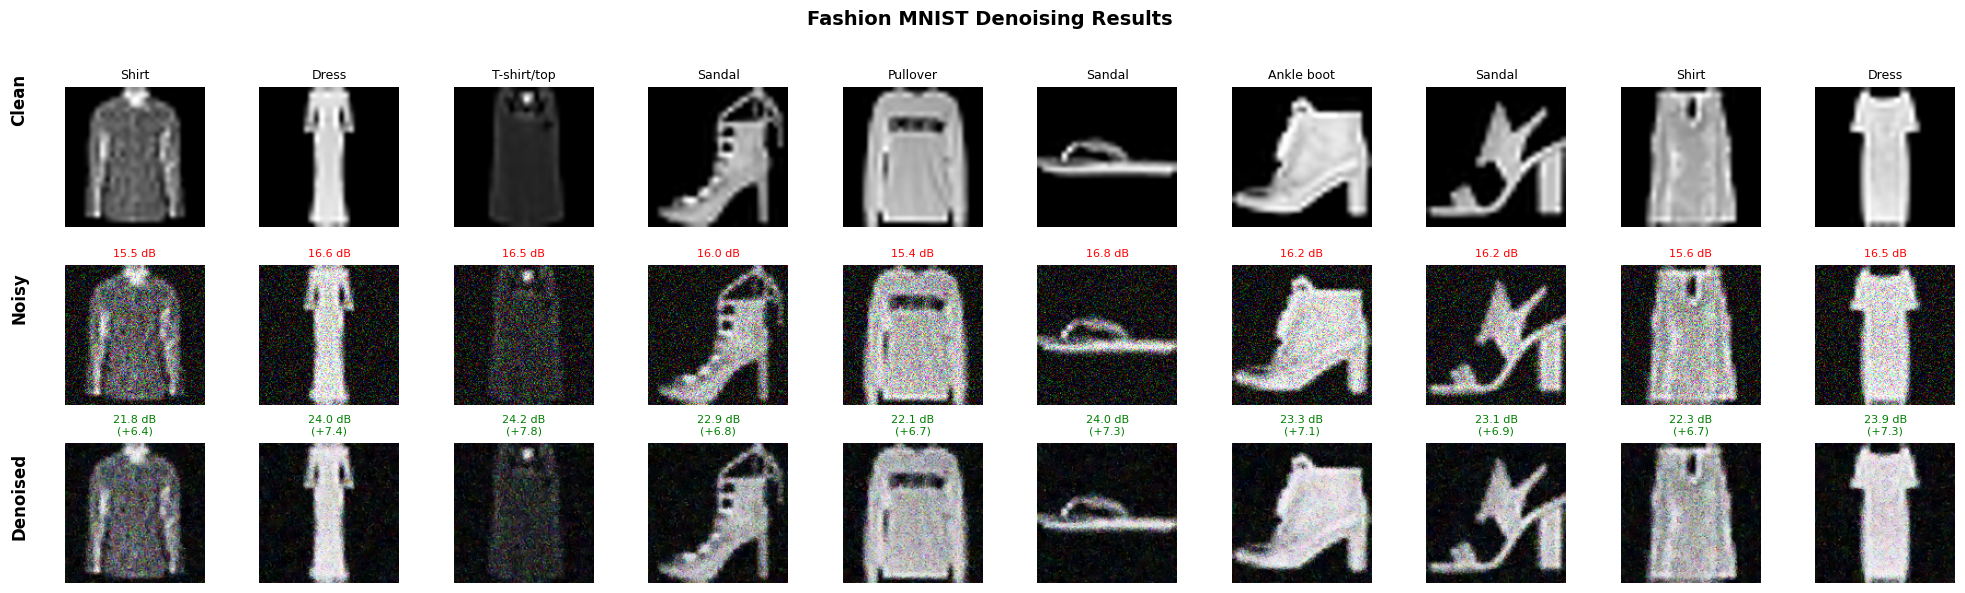


 Average Improvement: +7.04 dB
   Min improvement: +6.36 dB
   Max improvement: +7.75 dB


In [27]:
# Cell: Visualize Fashion MNIST results
print("\n Visualizing Results...\n")

fig, axes = plt.subplots(3, 10, figsize=(20, 6))

for i, result in enumerate(results):
    # Original (clean)
    axes[0, i].imshow(result['clean'])
    axes[0, i].set_title(f"{result['label']}", fontsize=9)
    axes[0, i].axis('off')

    # Noisy
    axes[1, i].imshow(result['noisy'])
    axes[1, i].set_title(f"{result['psnr_noisy']:.1f} dB", fontsize=8, color='red')
    axes[1, i].axis('off')

    # Denoised
    axes[2, i].imshow(result['denoised'])
    axes[2, i].set_title(f"{result['psnr_denoised']:.1f} dB\n(+{result['improvement']:.1f})",
                        fontsize=8, color='green')
    axes[2, i].axis('off')

# Row labels
fig.text(0.01, 0.83, 'Clean', fontsize=12, fontweight='bold', va='center', rotation=90)
fig.text(0.01, 0.50, 'Noisy', fontsize=12, fontweight='bold', va='center', rotation=90)
fig.text(0.01, 0.17, 'Denoised', fontsize=12, fontweight='bold', va='center', rotation=90)

plt.suptitle('Fashion MNIST Denoising Results', fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0.02, 0, 1, 0.96])
plt.show()

# Calculate average improvement
avg_improvement = np.mean([r['improvement'] for r in results])
print(f"\n Average Improvement: +{avg_improvement:.2f} dB")
print(f"   Min improvement: +{min(r['improvement'] for r in results):.2f} dB")
print(f"   Max improvement: +{max(r['improvement'] for r in results):.2f} dB")

In [28]:
# Cell: Summary statistics
print("\n" + "="*70)
print("FASHION MNIST DENOISING SUMMARY")
print("="*70 + "\n")

print(f"Test set: 10 random Fashion MNIST images (128×128)")
print(f"Noise level: σ={noise_level}\n")

print("Results by category:")
for result in results:
    print(f"  {result['label']:15s}: {result['psnr_noisy']:5.2f} dB → {result['psnr_denoised']:5.2f} dB (+{result['improvement']:5.2f} dB)")

avg_noisy = np.mean([r['psnr_noisy'] for r in results])
avg_denoised = np.mean([r['psnr_denoised'] for r in results])
avg_improvement = np.mean([r['improvement'] for r in results])

print(f"\nAverage metrics:")
print(f"  Noisy:      {avg_noisy:.2f} dB")
print(f"  Denoised:   {avg_denoised:.2f} dB")
print(f"  Improvement: +{avg_improvement:.2f} dB")

print("\n" + "="*70)

if avg_improvement > 5:
    print("EXCELLENT! Model generalizes well to Fashion MNIST!")
elif avg_improvement > 3:
    print("✓ GOOD! Model works on Fashion MNIST with decent improvement")
else:
    print("Model struggles with Fashion MNIST (domain shift)")


FASHION MNIST DENOISING SUMMARY

Test set: 10 random Fashion MNIST images (128×128)
Noise level: σ=50

Results by category:
  Shirt          : 15.45 dB → 21.81 dB (+ 6.36 dB)
  Dress          : 16.61 dB → 23.98 dB (+ 7.37 dB)
  T-shirt/top    : 16.49 dB → 24.24 dB (+ 7.75 dB)
  Sandal         : 16.03 dB → 22.87 dB (+ 6.84 dB)
  Pullover       : 15.41 dB → 22.15 dB (+ 6.73 dB)
  Sandal         : 16.76 dB → 24.03 dB (+ 7.28 dB)
  Ankle boot     : 16.19 dB → 23.30 dB (+ 7.11 dB)
  Sandal         : 16.18 dB → 23.12 dB (+ 6.94 dB)
  Shirt          : 15.63 dB → 22.35 dB (+ 6.72 dB)
  Dress          : 16.55 dB → 23.85 dB (+ 7.31 dB)

Average metrics:
  Noisy:      16.13 dB
  Denoised:   23.17 dB
  Improvement: +7.04 dB

EXCELLENT! Model generalizes well to Fashion MNIST!
